# 07_reporting.ipynb — figures, LaTeX table, summary

# Cell 0 — perf env

In [1]:
# (same perf env)
import os
os.environ.setdefault("OMP_NUM_THREADS", "8")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "8")
os.environ.setdefault("MKL_NUM_THREADS", "8")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "8")

'8'

# Cell 1 — load metrics, sweeps, caches, helpers

In [2]:
from pathlib import Path
import json, sys, platform, warnings, math
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

warnings.filterwarnings("ignore")

ROOT = Path(".")
RESULTS = ROOT/"results"
METRICS = RESULTS/"metrics"
FIGS    = RESULTS/"figures"
TABLES  = RESULTS/"tables"
REPORT  = RESULTS/"report"
for p in [FIGS, TABLES, REPORT]:
    p.mkdir(parents=True, exist_ok=True)

def safe_load_csv(path):
    if not path.exists():
        print("! missing:", path)
        return pd.DataFrame()
    try:
        return pd.read_csv(path)
    except Exception as e:
        print("! could not read:", path, e)
        return pd.DataFrame()

# core metrics
combined = safe_load_csv(METRICS/"combined.csv")
m_qsvm   = safe_load_csv(METRICS/"qsvm_kernel.csv")
m_vqc    = safe_load_csv(METRICS/"vqc.csv")
m_svmk   = safe_load_csv(METRICS/"svm_kmer.csv") if (METRICS/"svm_kmer.csv").exists() else pd.DataFrame()
m_svm1   = safe_load_csv(METRICS/"svm_onehot_flat.csv") if (METRICS/"svm_onehot_flat.csv").exists() else pd.DataFrame()
ns_vqc   = safe_load_csv(METRICS/"noise_sweep_vqc.csv")
ns_qsvm  = safe_load_csv(METRICS/"noise_sweep_qsvm.csv")

# caches
ROC_DIR = RESULTS / "roc_cache"
CM_DIR  = RESULTS / "cm_cache"

# optional run report (timings)
timing = {}
rr = METRICS / "noise_sweep_run_report.json"
if rr.exists():
    try:
        with open(rr) as f:
            timing = json.load(f).get("timing", {})
    except Exception:
        timing = {}

# optional dataset + meta (from earlier steps)
enc_meta = {}
try:
    with open(ROOT/"data/processed/meta.json") as f:
        enc_meta = json.load(f)
except Exception:
    pass

appx_env = {}
try:
    with open(RESULTS/"appendix/environment.json") as f:
        appx_env = json.load(f)
except Exception:
    pass

def pick_test(df):
    if df.empty: return df
    if "split" in df.columns:
        return df[df["split"].str.lower()=="test"].copy()
    return df

# build test table (one row per model)
cands = []
if not combined.empty:
    cands.append(pick_test(combined))
for name, df in [("QSVM_kernel", m_qsvm), ("VQC", m_vqc), ("SVM_kmer", m_svmk), ("SVM_onehot", m_svm1)]:
    if not df.empty:
        z = df.copy()
        if "model" not in z.columns:
            z["model"] = name
        cands.append(pick_test(z))

if not cands:
    raise RuntimeError("No metrics found. Run 02/03/04/06 first.")

test_all = pd.concat(cands, ignore_index=True)

# normalize columns we care about
keep = ["model","acc","prec","rec","f1","auc"]
for col in keep:
    if col not in test_all.columns: test_all[col] = np.nan

test_all = (test_all[keep]
            .dropna(subset=["model"])
            .drop_duplicates(subset=["model"], keep="last")
            .sort_values("f1", ascending=False)
            .reset_index(drop=True))

test_all.to_csv(METRICS/"summary_test.csv", index=False)

# deltas vs baseline (SVM_kmer) if present
baseline = None
if "SVM_kmer" in test_all["model"].values:
    baseline = test_all.set_index("model").loc["SVM_kmer"]
    for m in test_all["model"].values:
        if m == "SVM_kmer": continue
        for k in ["acc","prec","rec","f1","auc"]:
            if not np.isnan(test_all.loc[test_all["model"]==m, k].values[0]) and not np.isnan(baseline[k]):
                test_all.loc[test_all["model"]==m, f"Δ{k}"] = test_all.loc[test_all["model"]==m, k].values[0] - baseline[k]
            else:
                test_all.loc[test_all["model"]==m, f"Δ{k}"] = np.nan

# pick best noise configs
def best_noise(df, topn=3):
    if df.empty: return pd.DataFrame()
    t = df[df["split"]=="test"].copy()
    if t.empty: return t
    cols = [c for c in ["shots","pflip","pdepol","anchors","S_NOISE"] if c in t.columns]
    return (t.groupby(cols)["f1"].mean()
             .reset_index()
             .sort_values("f1", ascending=False)
             .head(topn))

best_vqc  = best_noise(ns_vqc, 5)
best_qsvm = best_noise(ns_qsvm, 5)

print("Summary rows:", len(test_all))
display(test_all)
print("\nBest VQC noise configs:")
display(best_vqc)
print("\nBest QSVM noise configs:")
display(best_qsvm)

Summary rows: 4


,model,acc,prec,rec,f1,auc,Δacc,Δprec,Δrec,Δf1,Δauc
0,QSVM_kernel,0.922819,0.922819,1.000000,0.959860,0.787510,0.003356,0.00026,0.003636,0.001818,0.013123
1,VQC,0.922819,0.922819,1.000000,0.959860,0.510988,0.003356,0.00026,0.003636,0.001818,-0.263399
2,SVM_onehot,0.922819,0.922819,1.000000,0.959860,0.756047,0.003356,0.00026,0.003636,0.001818,-0.018340
3,SVM_kmer,0.919463,0.922559,0.996364,0.958042,0.774387,NaN,NaN,NaN,NaN,NaN



Best VQC noise configs:


,shots,pflip,pdepol,f1
1,256,0.01,0.0,0.851562
0,256,0.00,0.0,0.847059



Best QSVM noise configs:


,shots,pflip,pdepol,anchors,S_NOISE,f1
0,256,0.01,0.0,96.0,16.0,0.957895


# Cell 2 — export LaTeX table + richer figures (ROC, CM, bars, noise heatmaps)

Wrote: results\tables\summary_test.tex


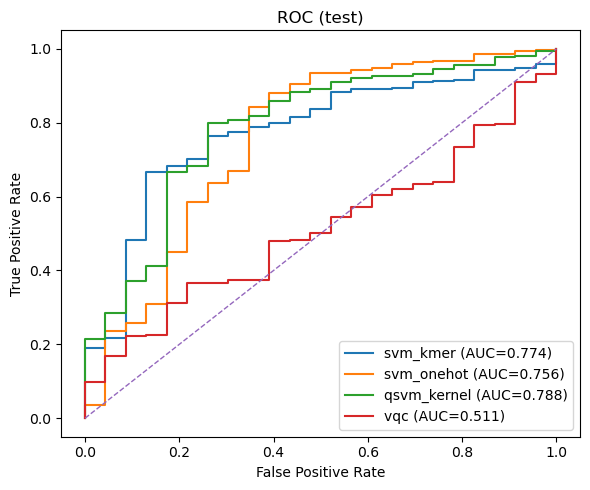

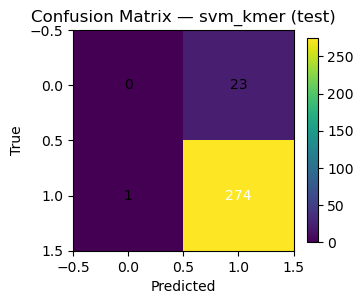

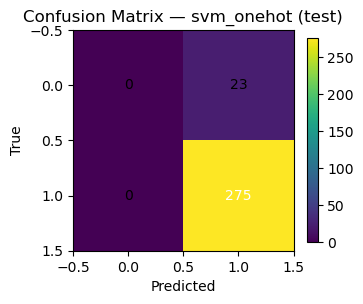

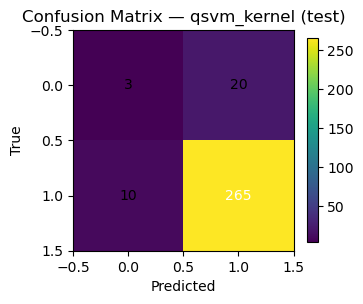

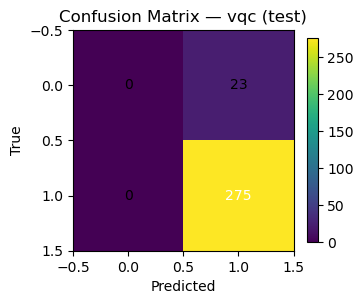

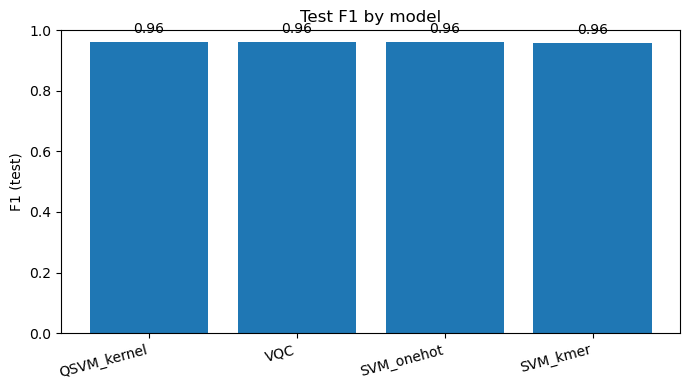

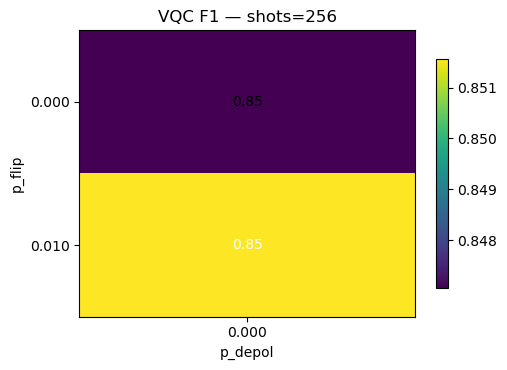

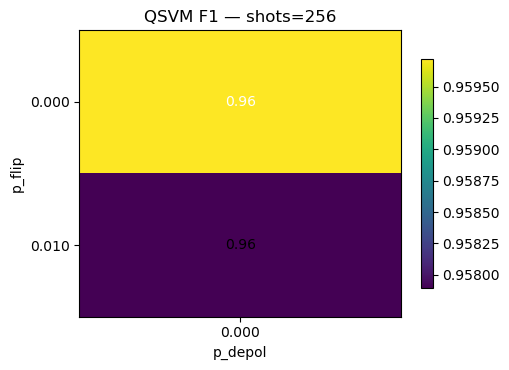

In [3]:
# LaTeX export
latex = test_all[["model","acc","prec","rec","f1","auc"]].rename(
    columns={"acc":"Accuracy","prec":"Precision","rec":"Recall","f1":"F1","auc":"ROC-AUC"}
).set_index("model")
with open(TABLES/"summary_test.tex","w") as f:
    f.write(latex.to_latex(float_format="%.3f", escape=True))
print("Wrote:", TABLES/"summary_test.tex")

# ---- ROC (if cached) ----
if ROC_DIR.exists() and (ROC_DIR/"y_test.npy").exists():
    y_test = np.load(ROC_DIR/"y_test.npy")
    items = []
    for name in ["svm_kmer","svm_onehot","qsvm_kernel","vqc"]:
        pfile = ROC_DIR / f"probs_{name}.npy"
        if pfile.exists():
            items.append((name, np.load(pfile)))
    if items:
        fig, ax = plt.subplots(figsize=(6,5))
        for name, probs in items:
            fpr, tpr, _ = roc_curve(y_test, probs)
            auc = roc_auc_score(y_test, probs)
            ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        ax.plot([0,1],[0,1],"--", lw=1)
        ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
        ax.set_title("ROC (test)"); ax.legend()
        fig.tight_layout(); fig.savefig(FIGS/"roc_test.png", dpi=200); plt.show()
    else:
        print("No ROC cache found.")
else:
    print("No ROC cache directory or y_test.npy.")

# ---- Confusion matrices (if cached predicted labels) ----
try:
    if CM_DIR.exists() and (CM_DIR/"y_true.json").exists():
        import json as _json
        with open(CM_DIR/"y_true.json") as f:
            y_true = np.array(_json.load(f))
        for name in ["svm_kmer","svm_onehot","qsvm_kernel","vqc"]:
            yp = CM_DIR / f"y_pred_{name}.json"
            if not yp.exists(): 
                continue
            with open(yp) as f:
                y_pred = np.array(_json.load(f))
            cm = confusion_matrix(y_true, y_pred)
            fig, ax = plt.subplots(figsize=(3.8,3.3))
            im = ax.imshow(cm)
            ax.set_title(f"Confusion Matrix — {name} (test)")
            ax.set_xlabel("Predicted"); ax.set_ylabel("True")
            for (i,j), v in np.ndenumerate(cm):
                ax.text(j, i, int(v), ha="center", va="center", color=("white" if im.norm(v)>0.5 else "black"))
            fig.colorbar(im, ax=ax, shrink=0.8)
            fig.tight_layout(); fig.savefig(FIGS/f"cm_{name}.png", dpi=200); plt.show()
except Exception as e:
    print("CM render skipped:", e)

# ---- Bar chart for F1 ----
if not test_all.empty:
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(test_all["model"], test_all["f1"])
    ax.set_ylim(0, 1); ax.set_ylabel("F1 (test)"); ax.set_title("Test F1 by model")
    for i, v in enumerate(test_all["f1"].values):
        ax.text(i, v + 0.02, f"{v:.2f}", ha="center", va="bottom")
    plt.xticks(rotation=15, ha="right"); plt.tight_layout()
    fig.savefig(FIGS/"bar_f1_test.png", dpi=200); plt.show()

# ---- Heatmaps for noise sweeps (if available) ----
def heatmap_from_pivot(df, name):
    if df.empty:
        print(f"No data for {name} heatmap.")
        return
    # we’ll aggregate by shots x (pflip,pdepol) → mean F1
    keycols = [c for c in ["shots","pflip","pdepol"] if c in df.columns]
    t = df[df["split"]=="test"][keycols+["f1"]].copy()
    if t.empty: 
        print(f"No test split in {name}.")
        return
    # Build a matrix per shots to visualize noise effect
    for sh in sorted(t["shots"].unique()):
        sub = t[t["shots"]==sh].copy()
        sub["label"] = sub.apply(lambda r: f"pflip={r['pflip']:.3f}", axis=1)
        # columns: by pdepol
        cols = sorted(sub["pdepol"].unique())
        rows = sorted(sub["pflip"].unique())
        M = np.zeros((len(rows), len(cols))) + np.nan
        for i, pf in enumerate(rows):
            for j, pd in enumerate(cols):
                vals = sub[(sub["pflip"]==pf) & (sub["pdepol"]==pd)]["f1"].values
                if len(vals):
                    M[i,j] = np.mean(vals)
        fig, ax = plt.subplots(figsize=(5.2,3.8))
        im = ax.imshow(M, aspect="auto", origin="upper")
        ax.set_xticks(range(len(cols))); ax.set_xticklabels([f"{c:.3f}" for c in cols])
        ax.set_yticks(range(len(rows))); ax.set_yticklabels([f"{r:.3f}" for r in rows])
        ax.set_xlabel("p_depol"); ax.set_ylabel("p_flip"); ax.set_title(f"{name} F1 — shots={sh}")
        for (i,j), v in np.ndenumerate(M):
            if not np.isnan(v):
                ax.text(j, i, f"{v:.2f}", ha="center", va="center", color=("white" if im.norm(v)>0.6 else "black"))
        fig.colorbar(im, ax=ax, shrink=0.8)
        fig.tight_layout(); fig.savefig(FIGS/f"heat_{name}_shots{sh}.png", dpi=200); plt.show()

heatmap_from_pivot(ns_vqc,  "VQC")
heatmap_from_pivot(ns_qsvm, "QSVM")

# Cell 3 — executive summary & markdown

In [4]:
# Executive summary (Markdown + file)
lines = []
lines.append("# Results Summary\n")

if not test_all.empty:
    best = test_all.iloc[0]
    base_txt = ""
    if "SVM_kmer" in test_all["model"].values:
        base = test_all.set_index("model").loc["SVM_kmer"]
        best_delta = best["f1"] - base["f1"] if not np.isnan(base["f1"]) else np.nan
        base_txt = f" vs SVM_kmer ΔF1={best_delta:+.3f}" if not np.isnan(best_delta) else ""
    lines.append(f"- **Best test F1:** {best['f1']:.3f} ({best['model']}){base_txt}; "
                 f"Acc={best['acc']:.3f}, Prec={best['prec']:.3f}, Rec={best['rec']:.3f}, ROC-AUC={best['auc']:.3f}\n")

    if "Δf1" in [c.lower() for c in test_all.columns]:
        # already computed deltas; show top 3 improvements over baseline if available
        pass

else:
    lines.append("- Metrics not found; run training notebooks first.\n")

if enc_meta:
    lines.append("## Dataset/Encoding\n")
    lines.append(f"- Accession: `{enc_meta.get('accession','?')}`")
    lines.append(f"- Window: {enc_meta.get('window','?')}  |  Stride: {enc_meta.get('stride','?')}")
    lines.append(f"- Total samples: {enc_meta.get('n_samples','?')}\n")

if not ns_vqc.empty or not ns_qsvm.empty:
    lines.append("## Noise & Shots — Top configs")
    if not best_vqc.empty:
        lines.append("**VQC (by mean test F1):**")
        for r in best_vqc.itertuples():
            items = [f"shots={getattr(r,'shots',None)}", f"pflip={getattr(r,'pflip',None)}", f"pdepol={getattr(r,'pdepol',None)}"]
            if hasattr(r,'S_NOISE'): items.append(f"S_NOISE={r.S_NOISE}")
            lines.append(f"- {', '.join(map(str,items))} → F1={r.f1:.3f}")
    if not best_qsvm.empty:
        lines.append("**QSVM (by mean test F1):**")
        for r in best_qsvm.itertuples():
            items = [f"shots={getattr(r,'shots',None)}", f"pflip={getattr(r,'pflip',None)}", f"pdepol={getattr(r,'pdepol',None)}"]
            if hasattr(r,'anchors'): items.append(f"anchors={r.anchors}")
            lines.append(f"- {', '.join(map(str,items))} → F1={r.f1:.3f}")

lines.append("\n## Artifacts")
lines.append("- `results/metrics/summary_test.csv`")
lines.append("- `results/figures/roc_test.png`, `bar_f1_test.png`, `cm_*.png`, `heat_*_shots*.png`")
lines.append("- `results/tables/summary_test.tex`")
lines.append("- `results/report/DNA_QML_Results_Report.docx` / `.pdf`")

(REPORT / "SUMMARY.md").write_text("\n".join(lines), encoding="utf-8")
print("Wrote:", REPORT/"SUMMARY.md")
print((REPORT/"SUMMARY.md").read_text()[:600], "...")

Wrote: results\report\SUMMARY.md
# Results Summary

- **Best test F1:** 0.960 (QSVM_kernel) vs SVM_kmer ΔF1=+0.002; Acc=0.923, Prec=0.923, Rec=1.000, ROC-AUC=0.788

## Dataset/Encoding

- Accession: `KF986530.1`
- Window: 256  |  Stride: 128
- Total samples: 1490

## Noise & Shots — Top configs
**VQC (by mean test F1):**
- shots=256, pflip=0.01, pdepol=0.0 → F1=0.852
- shots=256, pflip=0.0, pdepol=0.0 → F1=0.847
**QSVM (by mean test F1):**
- shots=256, pflip=0.01, pdepol=0.0, anchors=96.0 → F1=0.958

## Artifacts
- `results/metrics/summary_test.csv`
- `results/figures/roc_test.png`, `bar_f1_test.png`, `cm_*.png`, `heat_*_shot ...


# Cell 4 — prep artifacts for document builders

In [5]:
# Gather figure paths safely (if exist)
def _maybe(p): 
    p = Path(p)
    return str(p) if p.exists() else None

ART = {
    "ROC (test)":               _maybe(FIGS/"roc_test.png"),
    "F1 bar (test)":            _maybe(FIGS/"bar_f1_test.png"),
    "Confusion (svm_kmer)":     _maybe(FIGS/"cm_svm_kmer.png"),
    "Confusion (svm_onehot)":   _maybe(FIGS/"cm_svm_onehot.png"),
    "Confusion (qsvm_kernel)":  _maybe(FIGS/"cm_qsvm_kernel.png"),
    "Confusion (vqc)":          _maybe(FIGS/"cm_vqc.png"),
}

# plus any heatmaps generated
for p in FIGS.glob("heat_*_shots*.png"):
    ART[p.stem] = str(p)

print("Figures collected:", len([v for v in ART.values() if v]))
list(ART.items())[:5]

Figures collected: 8


[('ROC (test)', 'results\\figures\\roc_test.png'),
 ('F1 bar (test)', 'results\\figures\\bar_f1_test.png'),
 ('Confusion (svm_kmer)', 'results\\figures\\cm_svm_kmer.png'),
 ('Confusion (svm_onehot)', 'results\\figures\\cm_svm_onehot.png'),
 ('Confusion (qsvm_kernel)', 'results\\figures\\cm_qsvm_kernel.png')]

# Cell 5 — safe imports + helpers for DOCX/PDF

In [6]:
# Safe import & helpers
def ensure_imports():
    """Import python-docx & reportlab safely. Returns (DocxDocument, Inches, Pt, WD_ALIGN, reportlab_ok)."""
    DocxDocument = Inches = Pt = WD_ALIGN_PARAGRAPH = None
    reportlab_ok = True
    try:
        from docx import Document as DocxDocument
        from docx.shared import Inches, Pt
        from docx.enum.text import WD_ALIGN_PARAGRAPH
        from docx.enum.section import WD_ORIENT
        from docx.oxml.ns import qn
        from docx.oxml import OxmlElement
    except Exception as e:
        try:
            import subprocess, sys as _sys
            subprocess.check_call([_sys.executable, "-m", "pip", "install", "python-docx"])
            from docx import Document as DocxDocument
            from docx.shared import Inches, Pt
            from docx.enum.text import WD_ALIGN_PARAGRAPH
            from docx.enum.section import WD_ORIENT
            from docx.oxml.ns import qn
            from docx.oxml import OxmlElement
        except Exception as ee:
            print("! python-docx not available:", ee)
            DocxDocument = Inches = Pt = WD_ALIGN_PARAGRAPH = None

    try:
        from reportlab.lib.pagesizes import A4, landscape
        from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage, Table, TableStyle, PageBreak
        from reportlab.lib.styles import getSampleStyleSheet
        from reportlab.lib.units import inch
        from reportlab.lib import colors
    except Exception:
        reportlab_ok = False

    # stash extras in globals for orientation & field codes
    globals().update(locals())
    return DocxDocument, Inches, Pt, WD_ALIGN_PARAGRAPH, reportlab_ok

DocxDocument, Inches, Pt, WD_ALIGN_PARAGRAPH, REPORTLAB_OK = ensure_imports()

def _sys_info():
    import numpy, pandas, sklearn
    return {
        "Python": sys.version.split()[0],
        "Platform": f"{platform.system()} {platform.release()} ({platform.machine()})",
        "NumPy": numpy.__version__,
        "Pandas": pandas.__version__,
        "Scikit-learn": sklearn.__version__,
        "Matplotlib": plt.matplotlib.__version__,
    }

def _fmt_secs(sec):
    return f"{sec/60:.1f} min" if isinstance(sec,(int,float)) and sec >= 60 else f"{sec:.1f} s" if isinstance(sec,(int,float)) else "-"

def df_to_docx_table(doc, df):
    cols = list(df.columns)
    tbl = doc.add_table(rows=1, cols=len(cols))
    hdr = tbl.rows[0].cells
    for j, c in enumerate(cols):
        hdr[j].text = str(c)
    for _, row in df.iterrows():
        cells = tbl.add_row().cells
        for j, c in enumerate(cols):
            v = row[c]
            cells[j].text = f"{v:.3f}" if isinstance(v, float) else str(v)
    tbl.style = "Light List Accent 1"
    return tbl

def add_toc_field(doc):
    """Insert a Word TOC field that updates on open (References → Update Table in Word)."""
    try:
        from docx.oxml import OxmlElement
        from docx.oxml.ns import qn
        p = doc.add_paragraph()
        r = p.add_run()
        fld = OxmlElement('w:fldSimple')
        fld.set(qn('w:instr'), 'TOC \\o "1-3" \\h \\z \\u')
        r._r.append(fld)
    except Exception as e:
        doc.add_paragraph("(TOC field could not be inserted automatically)")

def add_section_landscape(doc):
    from docx.enum.section import WD_ORIENT
    section = doc.add_section()
    section.orientation = WD_ORIENT.LANDSCAPE
    new_w, new_h = section.page_height, section.page_width
    section.page_width, section.page_height = new_w, new_h
    return section

# Cell 6 — build advanced DOCX + PDF and preview

Saved:
 - results\report\DNA_QML_Results_Report.docx
 - results\report\DNA_QML_Results_Report.pdf

Preview — Test Metrics (DataFrame):


,model,acc,prec,rec,f1,auc,Δacc,Δprec,Δrec,Δf1,Δauc
0,QSVM_kernel,0.922819,0.922819,1.000000,0.959860,0.787510,0.003356,0.00026,0.003636,0.001818,0.013123
1,VQC,0.922819,0.922819,1.000000,0.959860,0.510988,0.003356,0.00026,0.003636,0.001818,-0.263399
2,SVM_onehot,0.922819,0.922819,1.000000,0.959860,0.756047,0.003356,0.00026,0.003636,0.001818,-0.018340
3,SVM_kmer,0.919463,0.922559,0.996364,0.958042,0.774387,NaN,NaN,NaN,NaN,NaN


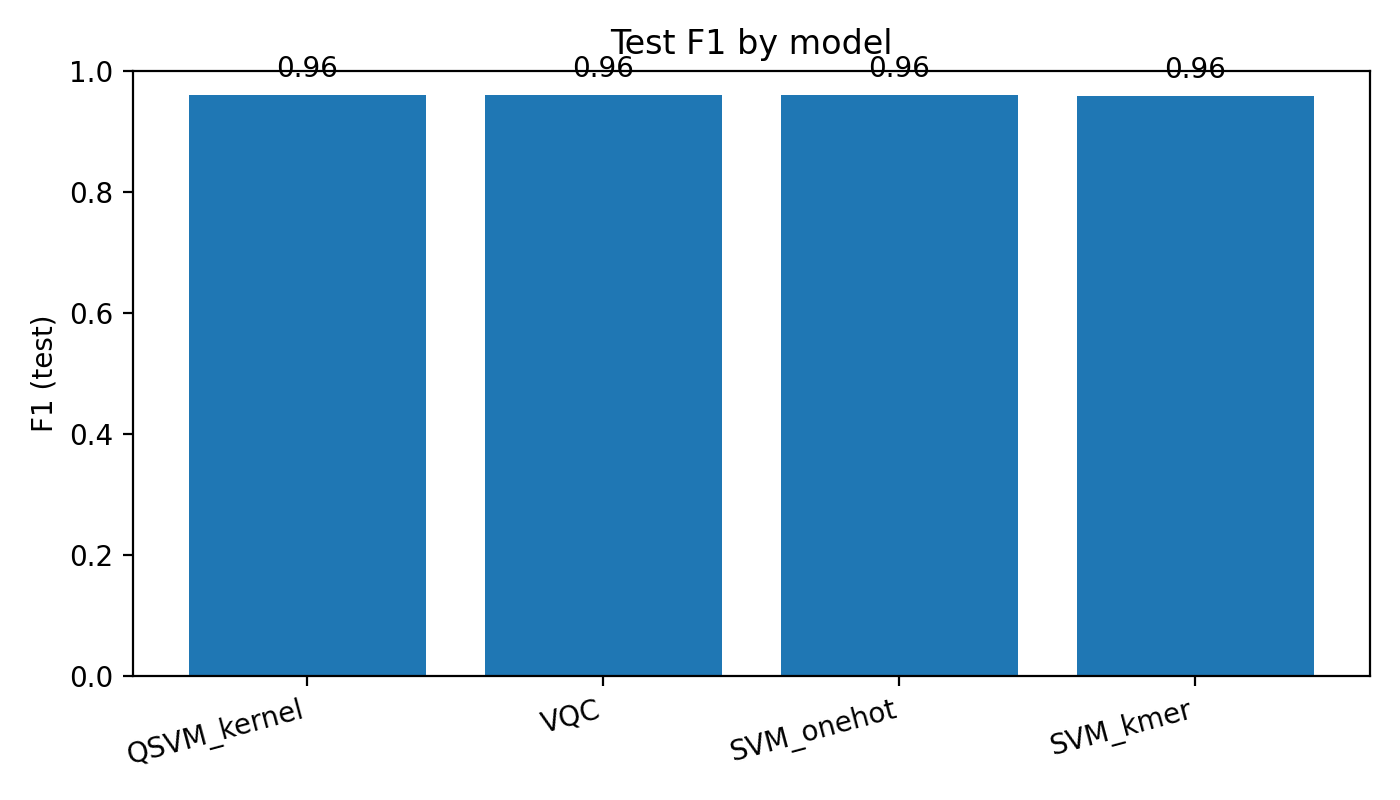

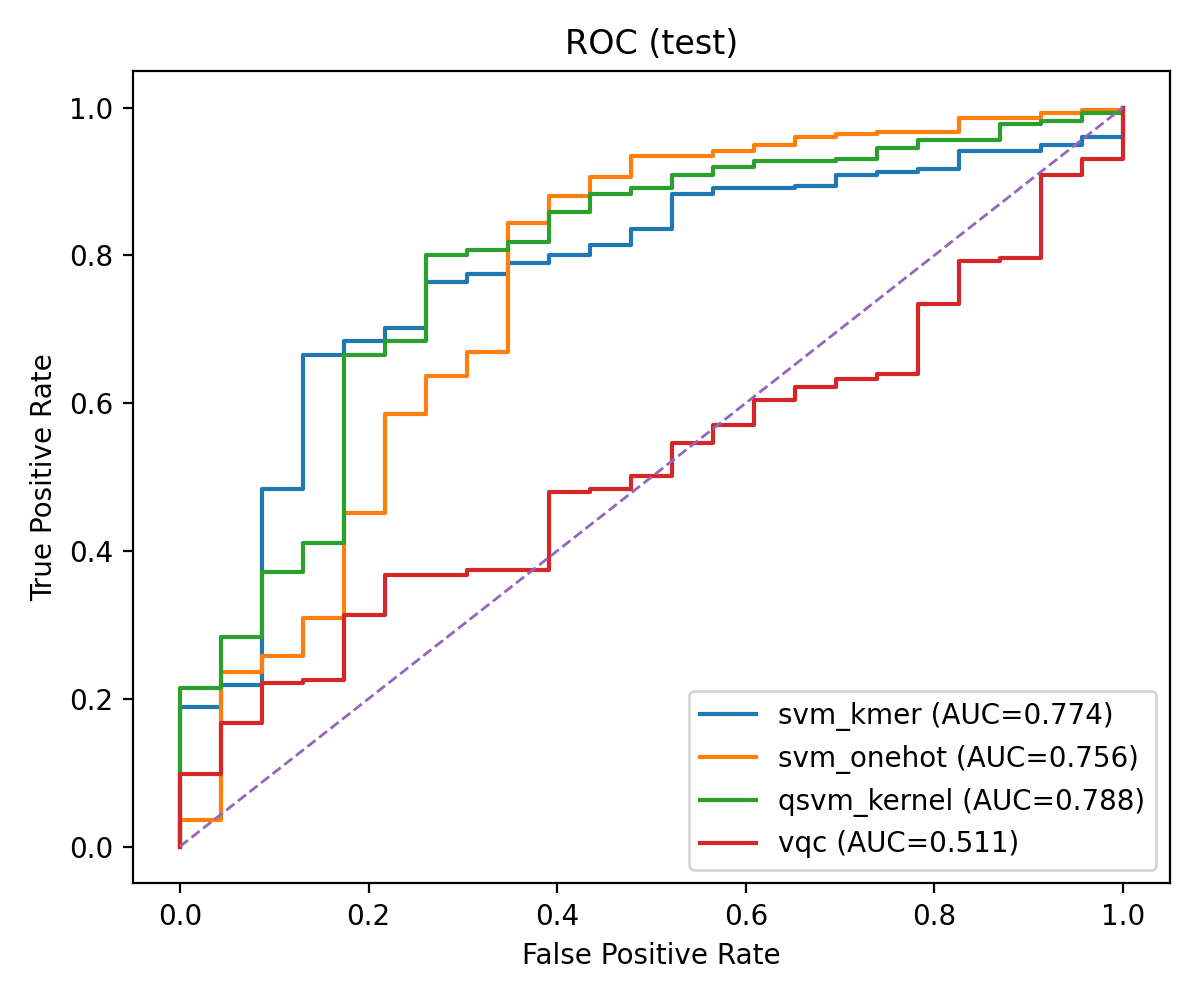

In [7]:
from datetime import datetime

DOCX_PATH = REPORT / "DNA_QML_Results_Report.docx"
PDF_PATH  = REPORT / "DNA_QML_Results_Report.pdf"

if DocxDocument is None:
    raise RuntimeError("python-docx not available. Please install python-docx and re-run this cell.")

doc = DocxDocument()

# ----- Cover -----
title = doc.add_heading("DNA QML — Results Report", level=0)
title.alignment = 1
doc.add_paragraph(datetime.now().strftime("%Y-%m-%d %H:%M")).alignment = 1
envp = doc.add_paragraph()
for k, v in _sys_info().items():
    envp.add_run(f"{k}: {v}\n").font.size = Pt(10)
doc.add_page_break()

# ----- TOC -----
doc.add_heading("Table of Contents", level=1)
add_toc_field(doc)
doc.add_page_break()

# ----- Executive Summary -----
doc.add_heading("Executive Summary", level=1)
if not test_all.empty:
    best = test_all.iloc[0]
    p = doc.add_paragraph()
    base_txt = ""
    if "SVM_kmer" in test_all["model"].values:
        base = test_all.set_index("model").loc["SVM_kmer"]
        if not np.isnan(base["f1"]):
            base_txt = f" (ΔF1 vs SVM_kmer: {best['f1']-base['f1']:+.3f})"
    p.add_run(f"Best model: {best['model']} with F1={best['f1']:.3f}{base_txt}; Acc={best['acc']:.3f}, Prec={best['prec']:.3f}, Rec={best['rec']:.3f}, AUC={best['auc']:.3f}.\n")
else:
    doc.add_paragraph("Metrics not found; ensure training/evaluation notebooks were executed.")

if enc_meta:
    doc.add_paragraph(f"Data accession: {enc_meta.get('accession','?')}; Window={enc_meta.get('window','?')}, Stride={enc_meta.get('stride','?')}, N={enc_meta.get('n_samples','?')}.")

# Best noise configs
if not ns_vqc.empty or not ns_qsvm.empty:
    doc.add_paragraph("Top noise/shot configurations (mean test F1):")
    if not best_vqc.empty:
        doc.add_paragraph("VQC:", style="Intense Quote")
        for r in best_vqc.itertuples():
            doc.add_paragraph(f"- shots={getattr(r,'shots',None)}, pflip={getattr(r,'pflip',None)}, pdepol={getattr(r,'pdepol',None)} → F1={r.f1:.3f}")
    if not best_qsvm.empty:
        doc.add_paragraph("QSVM:", style="Intense Quote")
        for r in best_qsvm.itertuples():
            extra = []
            if hasattr(r,"anchors"): extra.append(f"anchors={r.anchors}")
            doc.add_paragraph(f"- shots={getattr(r,'shots',None)}, pflip={getattr(r,'pflip',None)}, pdepol={getattr(r,'pdepol',None)} {', '.join(extra)} → F1={r.f1:.3f}")

# ----- Test Metrics Table -----
doc.add_heading("Test Metrics (one per model)", level=1)
df_to_docx_table(doc, test_all[["model","acc","prec","rec","f1","auc"]])

# ----- Figures -----
doc.add_heading("Figures", level=1)
for label, path in ART.items():
    if not path: 
        continue
    doc.add_paragraph(label).alignment = 1
    try:
        doc.add_picture(path, width=Inches(6))
    except Exception:
        doc.add_paragraph(f"(could not embed: {path})")
    cap = doc.add_paragraph(f"Figure: {label}")
    cap.alignment = 1

# ----- Landscape section for wide tables: noise pivots (if any) -----
# Try to build compact pivot tables for inclusion
def pivot_small(df, name):
    if df.empty: return None
    t = df[df["split"]=="test"].copy()
    if t.empty: return None
    cols = [c for c in ["shots","pflip","pdepol"] if c in t.columns]
    pv = t.groupby(cols)["f1"].mean().reset_index().sort_values("f1", ascending=False)
    pv = pv.head(20)  # keep it compact
    pv.insert(0, "model", name)
    return pv

pv_vqc  = pivot_small(ns_vqc, "VQC")
pv_qsvm = pivot_small(ns_qsvm, "QSVM")

if pv_vqc is not None or pv_qsvm is not None:
    add_section_landscape(doc)
    doc.add_heading("Top Noise/Shot Configurations (mean test F1)", level=1)
    if pv_vqc is not None:
        doc.add_paragraph("VQC — top rows")
        df_to_docx_table(doc, pv_vqc)
    if pv_qsvm is not None:
        doc.add_paragraph("QSVM — top rows")
        df_to_docx_table(doc, pv_qsvm)

# ----- Timing Summary -----
if timing:
    doc.add_heading("Timing Summary", level=1)
    for block_name in ["VQC","QSVM"]:
        dd = timing.get(block_name, {})
        if not dd: 
            continue
        doc.add_paragraph(block_name, style="Intense Quote")
        for k, v in dd.items():
            doc.add_paragraph(f"- {k}: {_fmt_secs(v)}")

# ----- Save DOCX -----
doc.save(str(DOCX_PATH))

# ----- PDF (ReportLab preferred; fallback to Matplotlib multipage) -----
if REPORTLAB_OK:
    from reportlab.lib.pagesizes import A4
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage, Table, TableStyle, PageBreak
    from reportlab.lib.styles import getSampleStyleSheet
    from reportlab.lib.units import inch
    from reportlab.lib import colors

    styles = getSampleStyleSheet()
    h1, h2, body = styles["Title"], styles["Heading2"], styles["BodyText"]
    story = []

    story.append(Paragraph("DNA QML — Results Report", h1))
    story.append(Paragraph(datetime.now().strftime("%Y-%m-%d %H:%M"), body))
    story.append(Spacer(1, 0.2*inch))
    story.append(Paragraph("Executive Summary", h2))
    if not test_all.empty:
        best = test_all.iloc[0]
        base_txt = ""
        if "SVM_kmer" in test_all["model"].values:
            base = test_all.set_index("model").loc["SVM_kmer"]
            if not np.isnan(base["f1"]):
                base_txt = f" (ΔF1 vs SVM_kmer: {best['f1']-base['f1']:+.3f})"
        story.append(Paragraph(f"Best model: {best['model']} with F1={best['f1']:.3f}{base_txt}; "
                               f"Acc={best['acc']:.3f}, Prec={best['prec']:.3f}, Rec={best['rec']:.3f}, AUC={best['auc']:.3f}.", body))
    if enc_meta:
        story.append(Paragraph(f"Accession: {enc_meta.get('accession','?')} — Window={enc_meta.get('window','?')}, "
                               f"Stride={enc_meta.get('stride','?')}, N={enc_meta.get('n_samples','?')}.", body))
    story.append(Spacer(1, 0.15*inch))

    # System
    story.append(Paragraph("Environment", h2))
    for k, v in _sys_info().items():
        story.append(Paragraph(f"{k}: {v}", body))
    story.append(Spacer(1, 0.15*inch))

    # Metrics table
    story.append(Paragraph("Test Metrics (one per model)", h2))
    data = [list(test_all.columns)] + [
        [f"{v:.3f}" if isinstance(v, float) else str(v) for v in row]
        for row in test_all.to_numpy()
    ]
    tbl = Table(data, hAlign="LEFT")
    tbl.setStyle(TableStyle([
        ("BACKGROUND", (0,0), (-1,0), colors.HexColor("#e8eef7")),
        ("GRID", (0,0), (-1,-1), 0.4, colors.grey),
        ("FONTNAME", (0,0), (-1,0), "Helvetica-Bold"),
        ("ALIGN", (1,1), (-1,-1), "CENTER"),
    ]))
    story.append(tbl)
    story.append(Spacer(1, 0.2*inch))

    # Timing
    if timing:
        story.append(Paragraph("Timing Summary", h2))
        for block_name in ["VQC","QSVM"]:
            dd = timing.get(block_name, {})
            if not dd: 
                continue
            story.append(Paragraph(f"<b>{block_name}</b>", body))
            for k, v in dd.items():
                story.append(Paragraph(f"{k}: {_fmt_secs(v)}", body))
        story.append(Spacer(1, 0.2*inch))

    # Figures
    story.append(Paragraph("Figures", h2))
    for label, path in ART.items():
        if not path: 
            continue
        story.append(Paragraph(label, body))
        try:
            story.append(RLImage(path, width=6*inch))
        except Exception:
            story.append(Paragraph(f"(could not embed: {path})", body))
        story.append(Spacer(1, 0.15*inch))

    SimpleDocTemplate(str(PDF_PATH), pagesize=A4).build(story)
else:
    # Fallback: simple multipage PDF
    from matplotlib.backends.backend_pdf import PdfPages
    with PdfPages(str(PDF_PATH)) as pdf:
        # Page 1: summary text
        fig, ax = plt.subplots(figsize=(8.27, 11.69))
        ax.axis("off")
        lines = ["DNA QML — Results Report", "", f"Generated: {datetime.now():%Y-%m-%d %H:%M}"]
        for k, v in _sys_info().items():
            lines.append(f"{k}: {v}")
        lines.append("")
        if not test_all.empty:
            lines.append("Test Metrics (top rows):")
            lines.append(test_all[["model","acc","prec","rec","f1","auc"]].to_string(index=False))
        ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left", fontsize=10, family="monospace")
        pdf.savefig(fig); plt.close(fig)

        # Add figures pages
        for label, path in ART.items():
            if not path: continue
            img = plt.imread(path)
            fig, ax = plt.subplots(figsize=(8.27, 11.69))
            ax.imshow(img); ax.axis("off")
            ax.set_title(label)
            pdf.savefig(fig); plt.close(fig)

print("Saved:")
print(" -", DOCX_PATH)
print(" -", PDF_PATH)

# ---- Preview in notebook ----
from IPython.display import display, Image as IPyImage
print("\nPreview — Test Metrics (DataFrame):")
display(test_all)

if (FIGS/"bar_f1_test.png").exists():
    display(IPyImage(filename=str(FIGS/"bar_f1_test.png")))
if (FIGS/"roc_test.png").exists():
    display(IPyImage(filename=str(FIGS/"roc_test.png")))